In [ ]:
%pwd

'/content'

In [ ]:
!git clone https://github.com/clovaai/CRAFT-pytorch.git

Cloning into 'CRAFT-pytorch'...
remote: Enumerating objects: 59, done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 59
Unpacking objects: 100% (59/59), done.


In [ ]:
#!git clone https://github.com/sujaykhandekar/Automated-objects-removal-inpainter.git
!git clone https://github.com/clovaai/deep-text-recognition-benchmark

Cloning into 'deep-text-recognition-benchmark'...
remote: Enumerating objects: 495, done.
remote: Total 495 (delta 0), reused 0 (delta 0), pack-reused 495
Receiving objects: 100% (495/495), 3.07 MiB | 21.51 MiB/s, done.
Resolving deltas: 100% (302/302), done.


In [ ]:
!pip install ipyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 10.1 MB/s 


In [ ]:
import sys

In [ ]:
sys.path.append('/content/CRAFT-pytorch')
sys.path.append('/content/deep-text-recognition-benchmark')


In [ ]:
# create dir for models
!mkdir weights
# craft main
!wget -O weights/craft_mlt_25k.pth https://drive.google.com/uc?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ&export=download
# craft refiner
!wget -O weights/craft_refiner_CTW1500.pth https://drive.google.com/uc?id=1XSaFwBkOaFOdtk4Ane3DFyJGPRw6v5bO&export=download
# deep text recongnition models
!wget -O weights/TPS-ResNet-BiLSTM-Attn.pth https://www.dropbox.com/sh/j3xmli4di1zuv3s/AADbTu4LF-nMUBmC43_RQ8OGa/TPS-ResNet-BiLSTM-Attn.pth?dl=1
!wget -O weights/TPS-ResNet-BiLSTM-CTC.pth https://www.dropbox.com/sh/j3xmli4di1zuv3s/AAB0X-sX05-0psb4uXWPYSmza/TPS-ResNet-BiLSTM-CTC.pth?dl=1
!gdown --id 1ajONZOgiG9pEYsQ-eBmgkVbMDuHgPCaY -O weights/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth 

--2022-10-23 19:50:37--  https://drive.google.com/uc?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ
Resolving drive.google.com (drive.google.com)... 74.125.197.102, 74.125.197.139, 74.125.197.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g1u33f3eqoebm71al1hidn4scho0ohnb/1666554600000/05173585031594261940/*/1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ?uuid=16bf0f8c-cf16-419b-a958-5be6d405dad7 [following]
--2022-10-23 19:50:41--  https://doc-0k-9g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g1u33f3eqoebm71al1hidn4scho0ohnb/1666554600000/05173585031594261940/*/1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ?uuid=16bf0f8c-cf16-419b-a958-5be6d405dad7
Resolving doc-0k-9g-docs.googleusercontent.com (doc-0k-9g-docs.googleusercontent.com)... 142.250.99.132, 2607:f8b0:400e:c0c::84
Connecting to doc-0k

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from shapely.geometry import Point, Polygon

import ipyplot

#### Craft imports
# import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT

from collections import OrderedDict


####### Craft Dataset

import re
import six
import math
import lmdb
import torch

from natsort import natsorted
from torch.utils.data import Dataset, ConcatDataset, Subset
from torch._utils import _accumulate
import torchvision.transforms as transforms




        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
#### Craft imports

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")


def create_craft_args(refine):

# --trained_model: pretrained model
# --text_threshold: text confidence threshold
# --low_text: text low-bound score
# --link_threshold: link confidence threshold
# --cuda: use cuda for inference (default:True)
# --canvas_size: max image size for inference
# --mag_ratio: image magnification ratio
# --poly: enable polygon type result
# --show_time: show processing time
# --test_folder: folder path to input images
# --refine: use link refiner for sentense-level dataset
# --refiner_model: pretrained refiner model

    args = argparse.Namespace()
    args.trained_model = 'weights/craft_mlt_25k.pth'
    # args.text_threshold = 0.6 # 0.7
    # args.low_text = 0.35 # 0.4
    # args.link_threshold = 0.6 # 0.4
    args.text_threshold = 0.6 # 0.7
    args.low_text = 0.35 # 0.4
    args.link_threshold = 0.7 # 0.4
    if torch.cuda.is_available():
        args.cuda = True
    else:
        args.cuda = False
    args.canvas_size = 1280
    args.mag_ratio = 1.5
    args.poly = False
    args.show_time = False
    args.test_folder = './data'
    args.refine = refine
    args.refiner_model = 'weights/craft_refiner_CTW1500.pth'
    return args

""" For test images in a folder """
# image_list, _, _ = file_utils.get_files(args.test_folder)

# result_folder = './result/'
# if not os.path.isdir(result_folder):
#     os.mkdir(result_folder)

def test_net(args, net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, args.canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=args.mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    if args.show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text


# def create_text_mask(args, image_array, debug=False):
#     # load net
#     net = CRAFT()     # initialize

#     if debug:
#         print('Loading weights from checkpoint (' + args.trained_model + ')')

#     if args.cuda:
#         net.load_state_dict(copyStateDict(torch.load(args.trained_model)))
#     else:
#         net.load_state_dict(copyStateDict(torch.load(args.trained_model, map_location='cpu')))

#     if args.cuda:
#         net = net.cuda()
#         net = torch.nn.DataParallel(net)
#         cudnn.benchmark = False

#     net.eval()

#     # LinkRefiner
#     refine_net = None
#     if args.refine:
#         from refinenet import RefineNet
#         refine_net = RefineNet()
        
#         if debug:
#             print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')

#         if args.cuda:
#             refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model)))
#             refine_net = refine_net.cuda()
#             refine_net = torch.nn.DataParallel(refine_net)
#         else:
#             refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

#         refine_net.eval()
#         args.poly = True

#     t = time.time()

#     image = image_array

#     bboxes, polys, score_text = test_net(args, net, image, args.text_threshold, args.link_threshold, args.low_text, args.cuda, args.poly, refine_net)

#     final_bboxes = np.around(bboxes).astype(int)

#     final_polys = [np.around(x).astype(int).reshape(-1).tolist() for x in polys]
#     # final_polys = [np.around(x).astype(int) for x in polys]

#     # return final_bboxes, final_polys
#     return bboxes, polys, score_text
def create_text_mask(refine, image_array, debug=False):
    # # load net
    # net = CRAFT()     # initialize

    # if debug:
    #     print('Loading weights from checkpoint (' + args.trained_model + ')')

    # if args.cuda:
    #     net.load_state_dict(copyStateDict(torch.load(args.trained_model)))
    # else:
    #     net.load_state_dict(copyStateDict(torch.load(args.trained_model, map_location='cpu')))

    # if args.cuda:
    #     net = net.cuda()
    #     net = torch.nn.DataParallel(net)
    #     cudnn.benchmark = False

    # net.eval()

    # # LinkRefiner
    # refine_net = None
    # if args.refine:
    #     from refinenet import RefineNet
    #     refine_net = RefineNet()
        
    #     if debug:
    #         print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')

    #     if args.cuda:
    #         refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model)))
    #         refine_net = refine_net.cuda()
    #         refine_net = torch.nn.DataParallel(refine_net)
    #     else:
    #         refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

    #     refine_net.eval()
    #     args.poly = True

    args, net, refine_net = init_craft_networks(refiner=refine, debug=debug)

    t = time.time()

    image = image_array

    bboxes, polys, score_text = test_net(args, net, image, args.text_threshold, args.link_threshold, args.low_text, args.cuda, args.poly, refine_net)

    final_bboxes = np.around(bboxes).astype(int)

    final_polys = [np.around(x).astype(int).reshape(-1).tolist() for x in polys]
    # final_polys = [np.around(x).astype(int) for x in polys]

    # return final_bboxes, final_polys
    return bboxes, polys, score_text

In [ ]:
def display_image_boxes(image_array, boxes):
    import PIL.ImageDraw as ImageDraw
    import PIL.Image as Image
    mask = Image.new("L", (image_array.shape[1], image_array.shape[0]))
    draw = ImageDraw.Draw(mask)
    for i in range(len(boxes)):
        draw.polygon(boxes[i], outline=256, fill=256)
    display(mask)


def transform_bboxes_to_rectangles(bboxes):
    rectangles = [[[x.min(axis=0)[0], x.min(axis=0)[1]],
                    [x.max(axis=0)[0], x.min(axis=0)[1]],
                    [x.max(axis=0)[0], x.max(axis=0)[1]],
                    [x.min(axis=0)[0], x.max(axis=0)[1]]] for x in bboxes]
    return np.array(rectangles)

def create_cutted_images_list(image_array, rectangles):
    list_ = []
    print("rectangles=", rectangles)
    for i in range(len(rectangles)):
        # display(Image.fromarray(np.array(mask)))
        x = rectangles[i].astype(int)
        list_.append(image_array[
        x[1][1]:x[3][1], 
        x[0][0]:x[2][0], 
        :
        ])
        
    return list_

def get_image_mask_from_boxes(image_array, boxes):
    import PIL.ImageDraw as ImageDraw
    import PIL.Image as Image
    mask = Image.new("L", (image_array.shape[1], image_array.shape[0]))
    draw = ImageDraw.Draw(mask)
    for i in range(len(boxes)):
        draw.polygon(boxes[i], outline=256, fill=256)
    return np.array(mask)

def create_word_2_sentence_index(word_bboxes, sentence_bboxes):

    result = {}

    for w_idx in range(len(word_bboxes)):
        arr = np.array([])
        for s_idx in range(len(sentence_bboxes)):
            word_polygon = Polygon(word_bboxes[w_idx])
            sent_polygon = Polygon(sentence_bboxes[s_idx])
            share_intersection = word_polygon.intersection(sent_polygon).area/word_polygon.area
            arr = np.append(arr, share_intersection)
        
        result[w_idx] = arr.argmax()
        # print(arr.tolist())
    
    return list(result.items())

def create_word_2_sentence_index_sorted(w2s_idx, word_rectangles):
    new_idx = sorted(w2s_idx, key=lambda x: (x[1], word_rectangles[:, 0, 0][x[0]]))

    return new_idx

def firts_work_upper_case(final_recognition_array, case_sensivity_recognition_array):
    for index in range(len(final_recognition_array)):
        if case_sensivity_recognition_array[index][0][0].isupper() and not final_recognition_array[index][0][0].isupper():
            final_recognition_array[index] = (final_recognition_array[index][0][0].upper() + final_recognition_array[index][0][1:], final_recognition_array[index][1])  
    
    return final_recognition_array
        

In [ ]:
####### Craft Dataset
import string

############################################
########## ХЗ может это и не нужно##########
############################################
class CustomsDataset(Dataset):
    def __init__(self, array_of_cutted_images, opt):
        self.opt = opt
        self.array_of_cutted_images = array_of_cutted_images
    def __len__(self):
        return len(self.array_of_cutted_images)
    def __getitem__(self, index):
        # (images, index_images) index_images = string/int - identifyer
        #return (self.array_of_cutted_images[index], index)
        if self.opt.rgb:
            img = Image.fromarray(self.array_of_cutted_images[index]).convert('RGB')  # for color image
        else:
            img = Image.fromarray(self.array_of_cutted_images[index]).convert('L')
        # print(f'Getted image for index {index}')
        return (img, str(index))

def recognition_pipeline(opt, word_cutted_images_list, debug=False):
    import string
    import argparse

    import torch
    import torch.backends.cudnn as cudnn
    import torch.utils.data
    import torch.nn.functional as F

    from utils import CTCLabelConverter, AttnLabelConverter
    from dataset import RawDataset, AlignCollate
    from model import Model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    """ model configuration """
    if 'CTC' in opt.Prediction:
        converter = CTCLabelConverter(opt.character)
    else:
        converter = AttnLabelConverter(opt.character)
    opt.num_class = len(converter.character)

    if opt.rgb:
        opt.input_channel = 3
    model = Model(opt)
    if debug:
        print('model input parameters', opt.imgH, opt.imgW, opt.num_fiducial, opt.input_channel, opt.output_channel,
            opt.hidden_size, opt.num_class, opt.batch_max_length, opt.Transformation, opt.FeatureExtraction,
            opt.SequenceModeling, opt.Prediction)
    model = torch.nn.DataParallel(model).to(device)

    if debug:
        print('Device %s' % device)

    # load model
    if debug:
        print('loading pretrained model from %s' % opt.saved_model)

    model.load_state_dict(torch.load(opt.saved_model, map_location=device))

    # prepare data. two demo images from https://github.com/bgshih/crnn#run-demo
    AlignCollate_demo = AlignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio_with_pad=opt.PAD)
    #demo_data = RawDataset(root=opt.image_folder, opt=opt)  # use RawDataset
    demo_data = CustomsDataset(word_cutted_images_list, opt=opt)
    if debug:
        print('CustomsDataset init')
    demo_loader = torch.utils.data.DataLoader(
        demo_data, batch_size=opt.batch_size,
        shuffle=False,
        num_workers=int(opt.workers),
        collate_fn=AlignCollate_demo, pin_memory=True)
    # print('demo_loader create')
    # predict
    model.eval()

    result = []
    with torch.no_grad():
        for image_tensors, image_path_list in demo_loader:
            # print(image_path_list)
            batch_size = image_tensors.size(0)
            image = image_tensors.to(device)
            # For max length prediction
            length_for_pred = torch.IntTensor([opt.batch_max_length] * batch_size).to(device)
            text_for_pred = torch.LongTensor(batch_size, opt.batch_max_length + 1).fill_(0).to(device)

            if 'CTC' in opt.Prediction:
                preds = model(image, text_for_pred)

                # Select max probabilty (greedy decoding) then decode index to character
                preds_size = torch.IntTensor([preds.size(1)] * batch_size)
                _, preds_index = preds.max(2)
                # preds_index = preds_index.view(-1)
                preds_str = converter.decode(preds_index, preds_size)

            else:
                preds = model(image, text_for_pred, is_train=False)

                # select max probabilty (greedy decoding) then decode index to character
                _, preds_index = preds.max(2)
                preds_str = converter.decode(preds_index, length_for_pred)


            log = open(f'./log_demo_result.txt', 'a')
            dashed_line = '-' * 80
            head = f'{"image_path":25s}\t{"predicted_labels":25s}\tconfidence score'
            
            # print(f'{dashed_line}\n{head}\n{dashed_line}')
            log.write(f'{dashed_line}\n{head}\n{dashed_line}\n')

            preds_prob = F.softmax(preds, dim=2)
            preds_max_prob, _ = preds_prob.max(dim=2)
            for img_name, pred, pred_max_prob in zip(image_path_list, preds_str, preds_max_prob):
                if 'Attn' in opt.Prediction:
                    pred_EOS = pred.find('[s]')
                    pred = pred[:pred_EOS]  # prune after "end of sentence" token ([s])
                    pred_max_prob = pred_max_prob[:pred_EOS]

                # calculate confidence score (= multiply of pred_max_prob)
                confidence_score = pred_max_prob.cumprod(dim=0)[-1]

                # print(f'{img_name:25s}\t{pred:25s}\t{confidence_score:0.4f}')
                log.write(f'{img_name:25s}\t{pred:25s}\t{confidence_score:0.4f}\n')
                result.append((pred, confidence_score.item()))
            log.close()
            return result

def create_word_recongnition_args(is_use_second_model=True, is_sensitive=False):
    opt = argparse.Namespace()
    opt.trained_model = 'weights/craft_mlt_25k.pth'
    opt.image_folder = "demo_image/" # NOT USED, DUMP
    opt.workers = 4
    opt.batch_size = 192
    opt.character = '0123456789abcdefghijklmnopqrstuvwxyz'
    # if is_use_second_model:
    #     opt.sensitive = True
    # else:
    #     opt.sensitive = False

    opt.sensitive = is_sensitive

    if is_use_second_model:
        if opt.sensitive:
            opt.saved_model = "weights/TPS-ResNet-BiLSTM-Attn-case-sensitive.pth" # !!!
        else:
            opt.saved_model = "weights/TPS-ResNet-BiLSTM-Attn.pth" # !!!
    else:
        opt.saved_model = "weights/TPS-ResNet-BiLSTM-CTC.pth" # !!!
        # """ Data processing """
    opt.batch_max_length = 25
    opt.imgH = 32 
    opt.imgW = 100
    opt.rgb = False 
    opt.PAD = True
    # """ Model Architecture """

    opt.Transformation = 'TPS'
    opt.FeatureExtraction = 'ResNet'
    opt.SequenceModeling = 'BiLSTM'
    if is_use_second_model:
        opt.Prediction = "Attn"
    else:
        opt.Prediction = "CTC"
    opt.num_fiducial = 20
    opt.input_channel = 1
    opt.output_channel = 512
    opt.hidden_size = 256
    """ vocab / character number configuration """
    if opt.sensitive:
        opt.character = string.printable[:-6]  # same with ASTER setting (use 94 char).

    cudnn.benchmark = True
    cudnn.deterministic = True
    opt.num_gpu = torch.cuda.device_count()

    return opt

def create_final_recognition_result(recognition_result_first, recognition_result_second):
    final_result_list = []
    for i in range(len(recognition_result_first)):
        if recognition_result_first[i][1] > recognition_result_second[i][1]:
            final_result_list.append(recognition_result_first[i])
        else:
            final_result_list.append(recognition_result_second[i])
        #print(recognition_result_first[i][0], recognition_result_second[i][0])
    #print(final_result_list)
    return final_result_list

In [ ]:
##########################################################################
###############Удаление текста с картинки#################################
##########################################################################

############ Object remover
# import os
# import glob
# import torch
# import random
# import numpy as np
# import torchvision.transforms.functional as F
# from torch.utils.data import DataLoader
# from PIL import Image
# from imageio import imread
# from skimage.feature import canny
# from skimage.color import rgb2gray, gray2rgb
# #from .utils import create_mask
# from src.utils import create_mask
# import cv2
# #from .segmentor_fcn import segmentor,fill_gaps
# from src.segmentor_fcn import segmentor,fill_gaps


# class DatasetForRemoveWithMask(torch.utils.data.Dataset):
#     def __init__(self, config, flist, edge_flist, image_data_list, augment=True, training=True, debug=True):
#         super(DatasetForRemoveWithMask, self).__init__()
#         self.augment = augment
#         self.training = training
#         self.data = self.load_flist(flist)
#         self.edge_data = self.load_flist(edge_flist)

#         self.debug = debug

#         self.input_size = config.INPUT_SIZE
#         self.sigma = config.SIGMA
#         self.edge = config.EDGE
#         self.mask = config.MASK
#         self.nms = config.NMS
#         self.device = config.SEG_DEVICE
#         self.objects = config.OBJECTS
#         self.segment_net = config.SEG_NETWORK
#         # in test mode, there's a one-to-one relationship between mask and image
#         # masks are loaded non random
        
#         # Наш массив с инфой
#         self.image_data_list = image_data_list

#     def __len__(self):
#         #######################################################################
#         #######################################################################
#         #######################################################################
#         #######################################################################
#         # НЕ ЗАБЫТЬ ПОМЕНЯТЬ НА ПРАВИЛЬНОЕ ЗНАЧЕНИЕ
#         # Если у будем обрабатывать более 1ой картинки, то
#         # len(self.image_data_list[0]["word_bboxes"]) > 0
#         #######################################################################
#         #######################################################################
#         #######################################################################
#         #######################################################################
#         return len(self.image_data_list[0]["word_bboxes"])
#         #return len(self.data)

#     def __getitem__(self, index):
#         try:
#             item = self.load_item(index)
#         except:
#             print("Load image - ", self.image_data_list[index]["image_path"])
#             item = self.load_item(index)

#         return item

#     def load_name(self, index):
#         return self.image_data_list[index]["image_file_name"]
        
#     def load_size(self, index):
#         # ХАРДКОД, модель не умеет работать с большими размерами
#         # Только с картинками 256 на 256
#         return 256, 256 

# #######################################################################
#     def centroid(self, vertexes):
#         _x_list = [vertex [0] for vertex in vertexes]
#         _y_list = [vertex [1] for vertex in vertexes]
#         _len = len(vertexes)
#         _x = sum(_x_list) / _len
#         _y = sum(_y_list) / _len
#         return(_x, _y)

#     def create_cutted_images_list_from_rectangle(self, image_array, rectangle):
#         # display(Image.fromarray(np.array(mask)))
#         #x = rectangle.astype(int)
#         x = rectangle

#         if self.debug:
#             print(x)
#             print((x[1][0] - x[0][0]))
#             print((x[1][1] - x[0][1]))

#         if np.ndim(image_array) > 2:
#             cutted_image =  image_array[
#             x[0][1]:x[1][1], 
#             x[0][0]:x[1][0], 
#             :
#             ]
#         else:
#             cutted_image =  image_array[
#             x[0][1]:x[1][1], 
#             x[0][0]:x[1][0]
#             ]
        
#         if self.debug:
#             print(cutted_image.shape)
#         return cutted_image
# #######################################################################

#     def load_item(self, index):

#         size = self.input_size

#         full_image = self.image_data_list[0]["image_with_deleted_text"]
#         full_mask = self.image_data_list[0]["mask_array_from_words"]

#         ################# CENTROID BOX ###################
#         box_points_list = self.image_data_list[0]['word_bboxes'][index]

#         center_point_x, center_point_y = self.centroid(box_points_list)

#         left_rect_point = center_point_x - size / 2
#         right_rect_point = center_point_x + size / 2
#         if left_rect_point < 0: # Левый край за нулем, смещаем rect вправо
#             right_rect_point -= left_rect_point 
#             left_rect_point = 0
        
#         if right_rect_point > self.image_data_list[0]['image_width']: # Левый край за нулем, смещаем rect вправо
#             width_delta = right_rect_point - self.image_data_list[0]['image_width']
#             right_rect_point -= width_delta 
#             left_rect_point -= width_delta 


#         top_rect_point = center_point_y - size / 2
#         bottom_rect_point = center_point_y + size / 2
#         if top_rect_point < 0: # Левый край за нулем, смещаем rect вправо
#             bottom_rect_point -= top_rect_point 
#             top_rect_point = 0

#         if bottom_rect_point > self.image_data_list[0]['image_height']: # Левый край за нулем, смещаем rect вправо
#             height_delta = bottom_rect_point - self.image_data_list[0]['image_height']
#             bottom_rect_point -= height_delta 
#             top_rect_point -= height_delta 


#         centroid_image_rectangle = [[left_rect_point, top_rect_point], [right_rect_point, bottom_rect_point]]
#         centroid_image_rectangle = np.array(centroid_image_rectangle)
#         centroid_image_rectangle = centroid_image_rectangle.astype(int)

#         cutted_image = self.create_cutted_images_list_from_rectangle(full_image, centroid_image_rectangle)
#         cutted_mask = self.create_cutted_images_list_from_rectangle(full_mask, centroid_image_rectangle)
#         ################# CENTROID BOX ###################

#         if self.debug:    
#             print("Load image - ", self.image_data_list[0]["image_path"])
#         # img = Image.fromarray(self.image_data_list[0]["image_array"])
#         #img = img.resize((size, size), Image.ANTIALIAS)
#         img = cutted_image
        
#         # gray to rgb
#         if Image.fromarray(img).mode !='RGB':
#             img = gray2rgb(img)

#         if self.debug:
#             print("img shape -", img.shape)
#             print("img type -", type(img))

#         mask = cutted_mask

#         # НАЛОЖЕНИЕ МАСКИ
#         # В маске есть "горящие" пиксели, которые нужно удалить и заменить
#         # дорисовать на их место фон. Мы выдираем пиксели
#         idx=(mask>0)
#         mask[idx]=255

#         # create grayscale image
#         img_gray = rgb2gray(np.array(img))


#         # load edge
#         edge = self.load_edge(img_gray, index, mask)

#         # augment data
#         if self.augment and np.random.binomial(1, 0.5) > 0:
#             img = img[:, ::-1, ...]
#             img_gray = img_gray[:, ::-1, ...]
#             edge = edge[:, ::-1, ...]
#             mask = mask[:, ::-1, ...]

#         return self.image_to_tensor(img), self.image_to_tensor(img_gray), self.image_to_tensor(edge), self.image_to_tensor(mask), F.to_tensor(centroid_image_rectangle).float(), cutted_image

#     def load_edge(self, img, index, mask):
#         sigma = self.sigma

#         # in test mode images are masked (with masked regions),
#         # using 'mask' parameter prevents canny to detect edges for the masked regions
#         mask = None if self.training else (1 - mask / 255).astype(np.bool)
        
#         # canny
#         if self.edge == 1:
#             # no edge
#             if sigma == -1:
#                 return np.zeros(img.shape).astype(np.float)

#             # random sigma
#             if sigma == 0:
#                 sigma = random.randint(1, 4)

#             return canny(img, sigma=sigma, mask=mask).astype(np.float)

#         # external
#         else:
#             imgh, imgw = img.shape[0:2]
#             edge = imread(self.edge_data[index])
#             edge = self.resized(edge, imgh, imgw)

#             # non-max suppression
#             if self.nms == 1:
#                 edge = edge * canny(img, sigma=sigma, mask=mask)

#             return edge

    
#     def image_to_tensor(self, img):
#         img = Image.fromarray(img)
#         img_t = F.to_tensor(img).float()
#         return img_t

#     def load_flist(self, flist):
#         if isinstance(flist, list):
#             return flist

#         # flist: image file path, image directory path, text file flist path
#         if isinstance(flist, str):
#             if os.path.isdir(flist):
#                 flist = list(glob.glob(flist + '/*.jpg')) + list(glob.glob(flist + '/*.png'))
#                 flist.sort()
#                 return flist

#             if os.path.isfile(flist):
#                 try:
#                     return np.genfromtxt(flist, dtype=np.str, encoding='utf-8')
#                 except:
#                     return [flist]

#         return []

#     def create_iterator(self, batch_size):
#         while True:
#             sample_loader = DataLoader(
#                 dataset=self,
#                 batch_size=batch_size,
#                 drop_last=True
#             )

#             for item in sample_loader:
#                 yield item

#     def postprocess(self, img):
#         # [0, 1] => [0, 255]
#         img = img * 255.0
#         #img = img.permutation(0, 2, 3, 1)
#         #return img.astype(int)
#         return img

# '''
#         Code of EdgeConnect is from this repo
#         https://github.com/knazeri/edge-connect
#         '''




# class EdgeConnectNew():
#     def __init__(self, config, image_data_list, debug=False):

#         self.config = config
        

#         if config.MODEL == 1:
#             model_name = 'edge'
#         elif config.MODEL == 2:
#             model_name = 'inpaint'
#         elif config.MODEL == 3:
#             model_name = 'edge_inpaint'
#         elif config.MODEL == 4:
#             model_name = 'joint'

#         #self.debug = True
#         self.debug = debug
#         self.model_name = model_name
#         self.edge_model = EdgeModel(config).to(config.DEVICE)
#         self.inpaint_model = InpaintingModel(config).to(config.DEVICE)
#         self.image_data_list = image_data_list
#         if self.debug:
#             print("--------------")
#             print("config.MODEL=", config.MODEL)
#             print(config.TEST_FLIST)
#             print(config.TEST_EDGE_FLIST)
#             print(self.model_name)
#             print(config)
#             print("--------------/")
#         # test mode
#         # config.TEST_FLIST - Путь до папки с файлами с картинками
#         self.test_dataset = DatasetForRemoveWithMask(
#             config, 
#             config.TEST_FLIST, 
#             config.TEST_EDGE_FLIST, 
#             image_data_list=self.image_data_list, 
#             augment=False, 
#             training=False,
#             debug=debug
#         )

#         self.samples_path = os.path.join(config.PATH, 'samples')
#         self.results_path = os.path.join(config.PATH, 'results')

#         if config.RESULTS is not None:
#             self.results_path = os.path.join(config.RESULTS)

#         if config.DEBUG is not None and config.DEBUG != 0:
#             self.debug = True

#         self.log_file = os.path.join(config.PATH, 'log_' + model_name + '.dat')

#     def load(self):
#         if self.config.MODEL == 1:
#             self.edge_model.load()

#         elif self.config.MODEL == 2:
#             self.inpaint_model.load()

#         else:
#             self.edge_model.load()
#             self.inpaint_model.load()

#     def save(self):
#         if self.config.MODEL == 1:
#             self.edge_model.save()

#         elif self.config.MODEL == 2 or self.config.MODEL == 3:
#             self.inpaint_model.save()

#         else:
#             self.edge_model.save()
#             self.inpaint_model.save()


#     def test(self):
#         self.edge_model.eval()
#         self.inpaint_model.eval()

#         model = self.config.MODEL
#         create_dir(self.results_path)

#         test_loader = DataLoader(
#             dataset=self.test_dataset,
#             batch_size=1,
#         )

#     def test(self):
#         self.edge_model.eval()
#         self.inpaint_model.eval()

#         model = self.config.MODEL
#         create_dir(self.results_path)

#         test_loader = DataLoader(
#             dataset=self.test_dataset,
#             batch_size=1,
#         )

#         index = 0
#         index_tmp = 0
#         for items in test_loader:
#             name = self.test_dataset.load_name(index) # Имя картинки которую обрабатываем

        
#             # Загруженная картинкаб сервый цвет
#             images, images_gray, edges, masks, centroid_image_rectangle, cutted_image = self.cuda(*items) 
            
#             ######################################################
#             ######################################################
#             # Проверка, не полностью ли у нас уже обработана маска (попали второй раз на тоже место)
#             current_mask = np.array(self.postprocess(masks)[0].cpu().numpy().astype(np.uint8))
#             current_mask = np.squeeze(current_mask) # Уменьшаем размерность
            
#             # В данной маске есть "пиксели для замены"
#             idx=(current_mask>0)
            
#             # Все индексы в данной маске = True, т.е. на этой картинке нам ничего закрашивать не нужно
#             if self.debug:
#                 print("idx.size == np.sum(idx)", idx.size, np.sum(idx))
#             #if idx.size == np.sum(idx):
#             if np.sum(idx) == 0:
#                 index_tmp += 1
#                 continue

#             # Проверка, не полностью ли у нас уже обработана маска (попали второй раз на тоже место)
#             ######################################################
#             ######################################################

#             # edge model
#             if model == 1:
#                 outputs = self.edge_model(images_gray, edges, masks)
#                 outputs_merged = (outputs * masks) + (edges * (1 - masks))

#             # inpaint model
#             elif model == 2:
#                 outputs = self.inpaint_model(images, edges, masks)
#                 outputs_merged = (outputs * masks) + (images * (1 - masks))

#             # inpaint with edge model / joint model
#             else:
#                 edges = self.edge_model(images_gray, edges, masks).detach()
#                 outputs = self.inpaint_model(images, edges, masks)
#                 outputs_merged = (outputs * masks) + (images * (1 - masks))

#             output = self.postprocess(outputs_merged)[0]            
#             path = os.path.join(self.results_path, name)
#             if self.debug:
#                 print(index, name)

#             imsave(output, path)

#             ############################################################################################################
#             ############ Заменяем пиксели в нашей старой картинке на новые пиксели ############
#             images_with_delete_text = output.cpu().numpy().astype(np.uint8)
#             cutted_image = cutted_image[0].cpu().numpy().astype(np.uint8)

#             cutted_image[idx] = images_with_delete_text[idx]
#             display(Image.fromarray(cutted_image))

#             #######################################################################
#             #######################################################################
#             #######################################################################
#             #######################################################################
#             # НЕ ЗАБЫТЬ ПОМЕНЯТЬ НА ПРАВИЛЬНОЕ ЗНАЧЕНИЕ
#             # Если у будем обрабатывать более 1ой картинки, то
#             # image_data_list[0] - нужно заменить на соответсвующий индекс
#             #######################################################################
#             #######################################################################
#             #######################################################################
#             #######################################################################
#             centroid_coordinate = centroid_image_rectangle.cpu().numpy().squeeze()
#             self.image_data_list[0]["image_with_deleted_text"][
#                 int(centroid_coordinate[0][1]):int(centroid_coordinate[1][1]), 
#                 int(centroid_coordinate[0][0]):int(centroid_coordinate[1][0]), 
#                 :
#             ][idx] = cutted_image[idx]

#             self.image_data_list[0]["mask_array_from_words"][
#                 int(centroid_coordinate[0][1]):int(centroid_coordinate[1][1]), 
#                 int(centroid_coordinate[0][0]):int(centroid_coordinate[1][0])
#             ][idx] = 0

#             if self.debug:
#                 display(Image.fromarray(self.image_data_list[0]["image_with_deleted_text"]))
#                 display(Image.fromarray(self.image_data_list[0]["mask_array_from_words"]))
#             ############ Заменяем пиксели в нашей старой картинке на новые пиксели ############
#             ############################################################################################################

            


#             if self.debug:
#                 print(images.shape)
#                 print(masks.shape)
#                 print(edges.shape)

#                 edges = self.postprocess(1 - edges)[0]
#                 masked = self.postprocess(images * (1 - masks) + masks)[0]
#                 fname, fext = name.split('.')

#                 imsave(edges, os.path.join(self.results_path, fname + '_edge.' + fext))
#                 imsave(masked, os.path.join(self.results_path, fname + '_masked.' + fext))

#             #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#             #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#             #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#             #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#             #index += 1
#             index_tmp += 1

#         if self.debug:
#             print('\nEnd test....')


#     def log(self, logs):
#         with open(self.log_file, 'a') as f:
#             f.write('%s\n' % ' '.join([str(item[1]) for item in logs]))

#     def cuda(self, *args):
#         return (item.to(self.config.DEVICE) for item in args)

#     def postprocess(self, img):
#         # [0, 1] => [0, 255]
#         img = img * 255.0
#         img = img.permute(0, 2, 3, 1)
#         return img.int()


####################################################################
####################################################################
####################################################################
# ######## Object remover MAIN
# import os
# import cv2
# import random
# import numpy as np
# import torch
# import argparse
# from shutil import copyfile
# from src.config import Config
# #from src.edge_connect import EdgeConnect


# def main(image_data_list, mode=None, debug=False):
#     r"""starts the model

#     """

#     config = load_object_remover_config(mode)


#     # cuda visble devices
#     os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(e) for e in config.GPU)


#     # init device
#     if torch.cuda.is_available():
#         config.DEVICE = torch.device("cuda")
#         torch.backends.cudnn.benchmark = True   # cudnn auto-tuner
#     else:
#         config.DEVICE = torch.device("cpu")



#     # set cv2 running threads to 1 (prevents deadlocks with pytorch dataloader)
#     cv2.setNumThreads(0)


#     # initialize random seed
#     torch.manual_seed(config.SEED)
#     torch.cuda.manual_seed_all(config.SEED)
#     np.random.seed(config.SEED)
#     random.seed(config.SEED)



#     # build the model and initialize
#     model = EdgeConnectNew(config, image_data_list)
#     model.load()


    
#     # model test
#     if debug:
#         print('\nstart testing...\n')
#     model.test()

    

# def load_object_remover_config(mode=None):
#     r"""loads model config

#     """
#     # parser = argparse.ArgumentParser()
#     # parser.add_argument('--path', '--checkpoints', type=str, default='./checkpoints', help='model checkpoints path (default: ./checkpoints)')
#     # parser.add_argument('--model', type=int, choices=[1, 2, 3, 4], help='1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: joint model')

#     # # test mode
#     # parser.add_argument('--input', type=str, help='path to the input images directory or an input image')
#     # parser.add_argument('--edge', type=str, help='path to the edges directory or an edge file')
#     # parser.add_argument('--output', type=str, help='path to the output directory')
#     # parser.add_argument('--remove', nargs= '*' ,type=int, help='objects to remove')
#     # parser.add_argument('--cpu', type=str, help='machine to run segmentation model on')
#     # args = parser.parse_args()
    
#     #!python test.py --input ./examples/my_small_data --output ./checkpoints/resultsfinal --remove 3 15

#     args = argparse.Namespace()
#     args.path = './checkpoints' # type=str, default='./checkpoints', help='model checkpoints path (default: ./checkpoints)')
#     args.model = 3 #', type=int, choices=[1, 2, 3, 4], help='1: edge model, 2: inpaint model, 3: edge-inpaint model, 4: joint model')

#     # # test mode
#     args.input = './examples/my_small_data' #, type=str, help='path to the input images directory or an input image')
#     args.edge = None # ', type=str, help='path to the edges directory or an edge file')
#     args.output = './checkpoints/resultsfinal' #', type=str, help='path to the output directory')
#     args.remove = [3,15] # ', nargs= '*' ,type=int, help='objects to remove')
#     args.cpu  = None #', type=str, help='machine to run segmentation model on')


#     #if path for checkpoint not given
#     if args.path is None:
#         args.path='./checkpoints'
#     config_path = os.path.join(args.path, 'config.yml')
    
#        # create checkpoints path if does't exist
#     if not os.path.exists(args.path):
#         os.makedirs(args.path)

#     # copy config template if does't exist
#     if not os.path.exists(config_path):
#         copyfile('./Automated-objects-removal-inpainter/config.yml.example', config_path)

#     # load config file
#     config = Config(config_path)

   
#     # test mode
#     config.MODE = 2
#     config.MODEL = args.model if args.model is not None else 3
#     config.OBJECTS = args.remove if args.remove is not None else [3,15]
#     config.SEG_DEVICE = 'cpu' if args.cpu is not None else 'cuda'
#     config.INPUT_SIZE = 256
#     if args.input is not None:
#         config.TEST_FLIST = args.input
    
#     if args.edge is not None:
#         # Дефолтное значение
#         # TEST_EDGE_FLIST: ./datasets/places2_edges_test.flist
#         config.TEST_EDGE_FLIST = args.edge
#     if args.output is not None:
#         config.RESULTS = args.output
#     else: 
#         if not os.path.exists('./results_images'):
#             os.makedirs('./results_images')
#         config.RESULTS = './results_images'
    
    
      
    
    
#     return config



In [ ]:
# def pipeline(image_link, debug=True):
    
#     image_path = image_link
#     image_file_name = os.path.basename(image_path)
#     image_pil = Image.open(BytesIO(requests.get(image_path).content))
#     source_image_for_output = image_pil.copy() # Исходная картинка которую мы подадим на выход для сравнения
#     if debug:
#         display('downloaded image', image_pil)
#     image_array = np.array(image_pil)

#     image_width = image_array.shape[1]
#     image_height = image_array.shape[0]
#     if debug:
#         print("Image width = ", image_width, "Image hight = ", image_height)

#     args = create_craft_args(refine=False)
#     word_bboxes, word_polys, word_score_text = create_text_mask(args, image_array)

#     #args = create_craft_args(refine=True)
#     #sentence_bboxes, sentence_polys, sentence_score_text = create_text_mask(args, image_array)

#     mask_array_from_words = get_image_mask_from_boxes(image_array, word_bboxes)
#     if debug:
#         display(Image.fromarray(mask_array_from_words))

#     word_rectangles = transform_bboxes_to_rectangles(word_bboxes)

#     ## Print finded words, but can throw Error
#     # if debug:
#     #     word_cutted_images_list = create_cutted_images_list(image_array, word_rectangles)
#     #     print('word_cutted_images_list', len(word_cutted_images_list))
#     #     for i in range(len(word_cutted_images_list)):
#     #         display(Image.fromarray(word_cutted_images_list[i]))

#     image_data_dictionary = {
#         "image_path": image_path,
#         "image_file_name": image_file_name,
#         "image_array": image_array.copy(),
#         "image_with_deleted_text": image_array.copy(), # Картинка в которой будем "удалять" текст
#         "image_width": image_width,
#         "image_height": image_height, 
#         "word_bboxes": word_bboxes.copy(),
#         "word_rectangles": word_rectangles,
#         "mask_array_from_words": mask_array_from_words.copy()
#     }
#     image_data_list = [image_data_dictionary]

#     # Удаление текста, mode это алгоритм который удаляет, второй это комбинированный из двух алгоритмов
#     main(image_data_list, mode=2)

#     image_with_deleted_text = Image.fromarray(image_data_list[0]["image_with_deleted_text"])

#     return source_image_for_output, image_with_deleted_text

In [ ]:
######## Font size detection
#from transformers import FSMTTokenizer, FSMTForConditionalGeneration
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union
import PIL.ImageDraw as ImageDraw

###################################################################
#####Перевод и текста и рисование текста###########################
###################################################################


def search_font_size(text, bbox, debug=False):
    width, height = bbox[2]-bbox[0]
    font_size = 1
    font = ImageFont.truetype("fonts/arial.ttf", font_size)
    font_width, font_height = font.getsize(text)
    if debug:
        print(width, height, font_width, font_height, font_size)
    while font_width < width and font_height < height:
        font_size += 1
        font = ImageFont.truetype("fonts/arial.ttf", font_size)
        font_width, font_height = font.getsize(text)
        if debug:
            print(width, height, font_width, font_height, font_size)
    font_size -= 1
    if debug:
        print(font_size)
        print(width, height, font_width, font_height, font_size)
    return ImageFont.truetype("fonts/arial.ttf", font_size)

# def compile_image(image, sentence_dict, sentence_bboxes):

#     image = image.copy()
#     draw = ImageDraw.Draw(image)

#     for idx, sentence in sentence_dict.items():
#         draw.text((sentence_bboxes[idx][0][0],sentence_bboxes[idx][0][1]), 
#                 sentence, 
#                 font=search_font_size(sentence, sentence_bboxes[idx]), 
#                 fill=(0, 0, 0), 
#                 stroke_width=2, 
#                 stroke_fill=(255,255,255))
#     return image
        

def create_sentence_dict(w2s_idx_sorted, recognized_word_list, sentence_bboxes):
    result = {}

    for el in w2s_idx_sorted:
        if el[1] in result.keys():
            result[el[1]]['list'].append((recognized_word_list[el[0]][0], recognized_word_list[el[0]][1], el[0]))
        else:
            result[el[1]] = {
                'list': [],
                'bbox': sentence_bboxes[el[1]]
            }
            result[el[1]]['list'].append((recognized_word_list[el[0]][0], recognized_word_list[el[0]][1], el[0]))
            #result[el[1]]['index_list'].append(el[0])

    return result

def translate_sentence(string, translator_model, translator_tokenizer):
    input_ids = translator_tokenizer.encode(string, return_tensors="pt")
    outputs = translator_model.generate(input_ids)
    decoded = translator_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded

def translate_sentence_dict(dict_, translator_model, translator_tokenizer, debug=False):

    result = {}

    for key, value in dict_.items():
        if debug:
            print(key, value)
        result[key] = translate_sentence(' '.join(value), translator_model, translator_tokenizer)
    return result

def bounds_to_bbox(x):
    return np.array([[x[0], x[1]], [x[2], x[1]], [x[2], x[3]], [x[0], x[3]]], dtype='float32')

def display_image_boxes(image_array, boxes):
    import PIL.ImageDraw as ImageDraw
    import PIL.Image as Image
    mask = Image.new("L", (image_array.shape[1], image_array.shape[0]))
    draw = ImageDraw.Draw(mask)
    font = ImageFont.truetype("fonts/arial.ttf", 12)
    for i in range(len(boxes)):
        draw.polygon(boxes[i], outline=256, fill=256)
        draw.text((boxes[i][0][0],boxes[i][0][1]), 
            text=str(i), 
            font=font)
    display(mask)

# TODO: РЕФАКТОРИНГ
# Тут скорее всего нужен рефакторинг т.к. не для всех будет работать правило
# Объединение по минимальной дистанции 10, скорее всего нужно будет смотреть на "размер ширкфат"
def create_paragraph_bboxes(sentence_bboxes
                            ):
    bboxes = sorted(sentence_bboxes,key=lambda x: x[0][0])
    paragraph_bboxes = []
    counter = 0
    # print('counter in ', counter)
    indexes = {x: 0 for x in list(range(len(sentence_bboxes)))}
    for num_master, box_master in enumerate(bboxes):
        for num_slave, box_slave in enumerate(bboxes):
            if indexes[num_master] == 0 and indexes[num_slave] == 0 and num_master != num_slave:
                # print('master ', num_master, 'slave ', num_slave)
                poly_master = Polygon(box_master)
                poly_slave = Polygon(box_slave)
                bounds_master = poly_master.bounds
                bounds_slave = poly_slave.bounds
                min_distance = poly_master.distance(poly_slave)

                # TODO: Сделать зависимость от размера шрифта
                if bounds_slave[0] < bounds_master[3] and min_distance <=10:
                    # print('append')
                    paragraph_bboxes.append(bounds_to_bbox(cascaded_union([poly_master, poly_slave]).bounds))
                    counter += 1
                    indexes[num_master] = 1
                    indexes[num_slave] = 1
        if indexes[num_master] == 0:
            paragraph_bboxes.append(box_master)
    # print('counter out ', counter)
    if counter == 0:
        return sentence_bboxes
    else:
        return create_paragraph_bboxes(paragraph_bboxes)

def create_word_2_sentence_index(word_bboxes, sentence_bboxes):

    result = {}

    for w_idx in range(len(word_bboxes)):
        arr = np.array([])
        for s_idx in range(len(sentence_bboxes)):
            word_polygon = Polygon(word_bboxes[w_idx])
            sent_polygon = Polygon(sentence_bboxes[s_idx])
            share_intersection = word_polygon.intersection(sent_polygon).area/word_polygon.area
            arr = np.append(arr, share_intersection)
        
        result[w_idx] = arr.argmax()
        # print(arr.tolist())
    
    return list(result.items())

def create_sentence_2_paragraph_index_sorted(sent2para_idx, sentence_bboxes):
    new_idx = sorted(sent2para_idx, key=lambda x: (x[1], sentence_bboxes[:, 0, 1][x[0]]))

    return new_idx

def create_paragraph_dict(sent2para_index_sorted, sentence_dict, paragraph_bboxes):

    result = {}

    for el in sent2para_index_sorted:
        if el[1] in result.keys():
            result[el[1]]['list'] = result[el[1]]['list'] + sentence_dict[el[0]]['list']
            result[el[1]]['splits'] += 1
        else:
            result[el[1]] = {
                'list': sentence_dict[el[0]]['list'],
                'splits': 0,
                'bbox': paragraph_bboxes[el[1]].tolist()
            }
    return result

# def translate_sentence(string):
#     input_ids = tokenizer.encode(string, return_tensors="pt")
#     outputs = model.generate(input_ids)
#     decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     return decoded

def translate_paragraph_dict(dict_, translator_model, translator_tokenizer, debug=False):

    result = {}

    for key in dict_.keys():
        result[key] = translate_sentence(' '.join(dict_[key]['list']), translator_model, translator_tokenizer)
        paragraph_array = result[key].split(' ')
        step = 0 if dict_[key]['splits']==0 else math.ceil(len(paragraph_array)/dict_[key]['splits'])
        if debug:
            print('step ', step)
        shuffle = 0
        if step > 0:
            for i in range(step, len(paragraph_array)+len(result[key])%step, step):
                if debug:
                    print(i)
                paragraph_array.insert(i+shuffle, '\n')
                shuffle += 1
        result[key] = ' '.join(paragraph_array)
    return result

def search_font_size(image, text, bbox, debug=False):
    if debug:
        print(bbox)
    width, height = bbox[2]-bbox[0]
    font_size = 1
    font = ImageFont.truetype("fonts/arial.ttf", font_size)
    # font_width, font_height = font.getsize(text)
    font_width, font_height = ImageDraw.ImageDraw(image).multiline_textsize(text, font=font)
    if debug:
        print('width {}, height {}, font_width {}, font_height {}, font_size {}'.format(width, height, font_width, font_height, font_size))
    while font_width < width :# and font_height < height:
        font_size += 1
        font = ImageFont.truetype("fonts/arial.ttf", font_size)
        # font_width, font_height = font.getsize(text)
        font_width, font_height = ImageDraw.ImageDraw(image).multiline_textsize(text, font=font)
        if debug:
            print('planned font size ', font.getsize(text))
            print('width {}, height {}, font_width {}, font_height {}, font_size {}'.format(width, height, font_width, font_height, font_size))
    font_size -= 1
    if debug:
        print('out font size ', font_size)
        print('width {}, height {}, font_width {}, font_height {}, font_size {}'.format(width, height, font_width, font_height, font_size))
    return ImageFont.truetype("fonts/arial.ttf", font_size)

def compile_image(image, sentence_dict, sentence_bboxes, debug):

    image = image.copy()
    draw = ImageDraw.Draw(image)

    for idx, sentence in sentence_dict.items():
        # draw.polygon(sentence_bboxes[idx], outline=256, fill=256)
        draw.text((sentence_bboxes[idx][0][0],sentence_bboxes[idx][0][1]), 
                sentence, 
                font=search_font_size(image, sentence, sentence_bboxes[idx], debug), 
                fill=(0, 0, 0), 
                stroke_width=2, 
                stroke_fill=(255,255,255))
    return image
        

In [ ]:
def init_craft_networks(refiner=False, debug=False):
    args = create_craft_args(refine=refiner)

    # load net
    net = CRAFT()  # initialize

    if debug:
        print('Loading weights from checkpoint (' + args.trained_model + ')')

    if args.cuda:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model)))
    else:
        net.load_state_dict(copyStateDict(torch.load(args.trained_model, map_location='cpu')))

    if args.cuda:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()

    # LinkRefiner
    refine_net = None
    if args.refine:
        from refinenet import RefineNet
        refine_net = RefineNet()

        if debug:
            print('Loading weights of refiner from checkpoint (' + args.refiner_model + ')')

        if args.cuda:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model)))
            refine_net = refine_net.cuda()
            refine_net = torch.nn.DataParallel(refine_net)
        else:
            refine_net.load_state_dict(copyStateDict(torch.load(args.refiner_model, map_location='cpu')))

        refine_net.eval()
        args.poly = True

    return args, net, refine_net

In [ ]:
#def pipeline(image_link, model_isr, model_translator, tokenizer_translator, font, debug=True):

def pipeline(image_link, debug=True):

    image_path = image_link
    image_file_name = os.path.basename(image_path)
    image_pil = Image.open(BytesIO(requests.get(image_path).content))
    source_image_for_output = image_pil.copy() # Исходная картинка которую мы подадим на выход для сравнения
    if debug:
        display('downloaded image', image_pil)
    image_array = np.array(image_pil)

    image_width = image_array.shape[1]
    image_height = image_array.shape[0]
    if debug:
        print("Image width = ", image_width, "Image hight = ", image_height)

    # args = create_craft_args(refine=False)
    # word_bboxes, word_polys, word_score_text = create_text_mask(args, image_array)

    # args = create_craft_args(refine=True)
    # sentence_bboxes, sentence_polys, sentence_score_text = create_text_mask(args, image_array)

    word_bboxes, word_polys, word_score_text = create_text_mask(False, image_array)
    sentence_bboxes, sentence_polys, sentence_score_text = create_text_mask(True, image_array)


    mask_array_from_words = get_image_mask_from_boxes(image_array, word_bboxes)

    word_rectangles = transform_bboxes_to_rectangles(word_bboxes)
    word_cutted_images_list = create_cutted_images_list(image_array, word_rectangles)

    if debug:
        print('word_cutted_images_list')
        for i in range(len(word_cutted_images_list)):
            display(Image.fromarray(word_cutted_images_list[i]))

        sent_rectangles = transform_bboxes_to_rectangles(sentence_bboxes)
        sent_cutted_images_list = create_cutted_images_list(image_array, sent_rectangles)
        print('sent_cutted_images_list')
        for i in range(len(sent_cutted_images_list)):
            display(Image.fromarray(sent_cutted_images_list[i]))


    image_data_dictionary = {
        "image_path": image_path,
        "image_file_name": image_file_name,
        "image_array": image_array.copy(),
        "image_width": image_width,
        "image_height": image_height, 
        "word_bboxes": word_bboxes,
        "word_rectangles": word_rectangles,
        "mask_array_from_words": mask_array_from_words
    }
    image_data_list = [image_data_dictionary]

    w2s_idx = create_word_2_sentence_index(word_bboxes, sentence_bboxes)
    if debug:
        print("w2s_idx=", w2s_idx)
        print("word_rectangles=", word_rectangles)

    w2s_idx_sorted = create_word_2_sentence_index_sorted(w2s_idx, word_rectangles)
    if debug:
        print("w2s_idx_sorted=", w2s_idx_sorted)

    opt = create_word_recongnition_args(is_use_second_model=False)
    recognition_result_1 = recognition_pipeline(opt, word_cutted_images_list, debug)

    if debug:
        print('recognition_result_1', recognition_result_1)
    
    opt = create_word_recongnition_args(is_use_second_model=True, is_sensitive=False)
    recognition_result_2 = recognition_pipeline(opt, word_cutted_images_list, debug)
    # Нужно для этой модели снизить вероятность у распознования
    recognition_result_2 = [(item[0], item[1]*0.7) for item in recognition_result_2]

    if debug:
        print('recognition_result_2', recognition_result_2)


    opt = create_word_recongnition_args(is_use_second_model=True, is_sensitive=True)
    recognition_result_sensitive = recognition_pipeline(opt, word_cutted_images_list, debug)

    if debug:
        print('recognition_result_sensitive', recognition_result_sensitive)

    if debug:
        print('recognition_result_1', recognition_result_1)
        print('recognition_result_2', recognition_result_2)
        print('recognition_result_sensitive', recognition_result_sensitive)

    # Из трех моделей распознования слов выбираем с максимальными шансами
    final_recognition_result = create_final_recognition_result(recognition_result_1, recognition_result_sensitive)
    final_recognition_result = create_final_recognition_result(final_recognition_result, recognition_result_2)
    final_recognition_result = firts_work_upper_case(final_recognition_result, recognition_result_sensitive)

    if debug:
        print('final_recognition_result', final_recognition_result)

    recognized_word_list = [x[0] for x in final_recognition_result]

    #sentence_dict = create_sentence_dict(w2s_idx_sorted, [x[0] for x in final_recognition_result])
    sentence_dict = create_sentence_dict(w2s_idx_sorted, final_recognition_result, sentence_bboxes)

    if debug:
        print('sentence_dict', sentence_dict)

    # # Удаление текста, mode это алгоритм который удаляет, второй это комбинированный из двух алгоритмов
    # main(image_data_list, mode=2)

    # image_super_resolution_processing(model_isr, image_data_list)

    # image_with_deleted_text = Image.fromarray(image_data_list[0]["image_with_deleted_text"])

    paragraph_bboxes = create_paragraph_bboxes(sentence_bboxes)
    if debug:
        print('paragraph_bboxes=', paragraph_bboxes)

    sent2para_index = create_word_2_sentence_index(sentence_bboxes, paragraph_bboxes)

    sent2para_index_sorted = create_sentence_2_paragraph_index_sorted(sent2para_index, sentence_bboxes)

    paragraph_dict = create_paragraph_dict(sent2para_index_sorted, sentence_dict, paragraph_bboxes)

    if debug:
        print('paragraph_dict', paragraph_dict)

    if debug:
        print("word_bboxes", word_bboxes)
        print("word_rectangles", word_rectangles)

    #paragraph_dict_translated = translate_paragraph_dict(paragraph_dict, model_translator, tokenizer_translator)

    #if debug:
    #    print('paragraph_dict_translated', paragraph_dict_translated)

    #compiled_image = compile_image(image_with_deleted_text, paragraph_dict_translated, paragraph_bboxes, debug)

    #return source_image_for_output, compiled_image
    #return source_image_for_output, source_image_for_output
    return paragraph_dict

## Введите URL до картинки и запустите ячейку

'downloaded image'

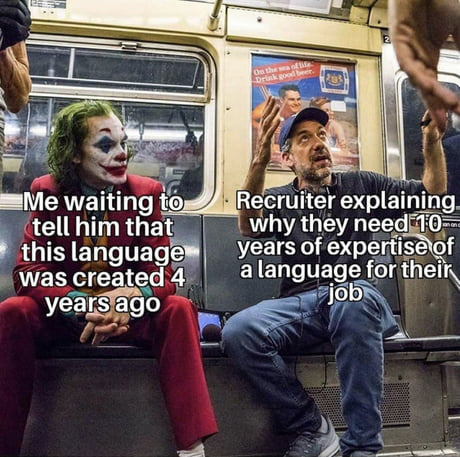

Image width =  460 Image hight =  457


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


rectangles= [[[338.35324  187.17505 ]
  [459.01297  187.17505 ]
  [459.01297  216.25081 ]
  [338.35324  216.25081 ]]

 [[ 60.451862 184.49397 ]
  [157.10149  184.49397 ]
  [157.10149  218.28581 ]
  [ 60.451862 218.28581 ]]

 [[235.60606  189.05682 ]
  [337.68387  189.05682 ]
  [337.68387  213.02557 ]
  [235.60606  213.02557 ]]

 [[ 22.666666 189.33333 ]
  [ 60.       189.33333 ]
  [ 60.       213.33333 ]
  [ 22.666666 213.33333 ]]

 [[157.33333  192.      ]
  [184.       192.      ]
  [184.       213.33333 ]
  [157.33333  213.33333 ]]

 [[249.33333  212.      ]
  [297.33334  212.      ]
  [297.33334  237.33333 ]
  [249.33333  237.33333 ]]

 [[297.25488  210.49413 ]
  [351.80386  210.49413 ]
  [351.80386  238.40782 ]
  [297.25488  238.40782 ]]

 [[352.       212.      ]
  [444.       212.      ]
  [444.       234.66667 ]
  [352.       234.66667 ]]

 [[ 29.333334 213.33333 ]
  [ 72.       213.33333 ]
  [ 72.       238.66667 ]
  [ 29.333334 238.66667 ]]

 [[ 72.       213.33333 ]
  [121.3

/content/CRAFT-pytorch/craft_utils.py:239: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys = np.array(polys)


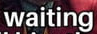

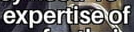

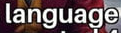

rectangles= [[[235.64815  185.40425 ]
  [459.01297  185.40425 ]
  [459.01297  216.25081 ]
  [235.64815  216.25081 ]]

 [[ 23.23523  185.0038  ]
  [184.63899  185.0038  ]
  [184.63899  219.22267 ]
  [ 23.23523  219.22267 ]]

 [[249.33331  211.99998 ]
  [443.9999   211.99998 ]
  [443.9999   237.33331 ]
  [249.33331  237.33331 ]]

 [[ 30.666666 214.66667 ]
  [176.       214.66667 ]
  [176.       238.66667 ]
  [ 30.666666 238.66667 ]]

 [[236.       234.66667 ]
  [457.33334  234.66667 ]
  [457.33334  261.33334 ]
  [236.       261.33334 ]]

 [[ 16.746374 237.09856 ]
  [187.14238  237.09856 ]
  [187.14238  271.24048 ]
  [ 16.746374 271.24048 ]]

 [[238.66664  258.66666 ]
  [457.33325  258.66666 ]
  [457.33325  284.      ]
  [238.66664  284.      ]]

 [[ 18.666666 265.33334 ]
  [186.66667  265.33334 ]
  [186.66667  289.33334 ]
  [ 18.666666 289.33334 ]]

 [[323.20364  279.70422 ]
  [367.2355   279.70422 ]
  [367.2355   307.6951  ]
  [323.20364  307.6951  ]]

 [[ 42.666668 292.      ]
  [162.6

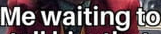

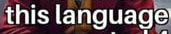

w2s_idx= [(0, 0), (1, 1), (2, 0), (3, 1), (4, 1), (5, 2), (6, 2), (7, 2), (8, 3), (9, 3), (10, 3), (11, 4), (12, 4), (13, 4), (14, 5), (15, 5), (16, 6), (17, 6), (18, 6), (19, 6), (20, 7), (21, 7), (22, 7), (23, 8), (24, 9), (25, 9)]
word_rectangles= [[[338.35324  187.17505 ]
  [459.01297  187.17505 ]
  [459.01297  216.25081 ]
  [338.35324  216.25081 ]]

 [[ 60.451862 184.49397 ]
  [157.10149  184.49397 ]
  [157.10149  218.28581 ]
  [ 60.451862 218.28581 ]]

 [[235.60606  189.05682 ]
  [337.68387  189.05682 ]
  [337.68387  213.02557 ]
  [235.60606  213.02557 ]]

 [[ 22.666666 189.33333 ]
  [ 60.       189.33333 ]
  [ 60.       213.33333 ]
  [ 22.666666 213.33333 ]]

 [[157.33333  192.      ]
  [184.       192.      ]
  [184.       213.33333 ]
  [157.33333  213.33333 ]]

 [[249.33333  212.      ]
  [297.33334  212.      ]
  [297.33334  237.33333 ]
  [249.33333  237.33333 ]]

 [[297.25488  210.49413 ]
  [351.80386  210.49413 ]
  [351.80386  238.40782 ]
  [297.25488  238.40782 ]]

 [[352.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


recognition_result_1 [('explaining', 0.5882282853126526), ('waiting', 0.8867615461349487), ('recruiter', 0.347575843334198), ('me', 0.14560890197753906), ('to', 0.5824127793312073), ('why', 0.7898136377334595), ('they', 0.9117652177810669), ('need10', 0.5399966239929199), ('tell', 0.725985050201416), ('him', 0.8779861927032471), ('that', 0.6222687363624573), ('of', 0.44411343336105347), ('expertiseof', 0.445390909910202), ('years', 0.9481896162033081), ('this', 0.5223450660705566), ('language', 0.9741808176040649), ('language', 0.944085419178009), ('for', 0.6455422639846802), ('their', 0.8967472314834595), ('a', 0.4052974581718445), ('created', 0.8061327934265137), ('4', 0.27983975410461426), ('was', 0.8550967574119568), ('job', 0.16474001109600067), ('years', 0.9148007035255432), ('agoo', 0.43406054377555847)]
model input parameters 32 100 20 1 512 256 38 25 TPS ResNet BiLSTM Attn
Device cuda
loading pretrained model from weights/TPS-ResNet-BiLSTM-Attn.pth
CustomsDataset init
recognit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.


In [ ]:
from google.colab import output
input_image_url = 'https://img-9gag-fun.9cache.com/photo/axMNd31_460s.jpg' #@param {type:"string"}


if input_image_url is not None and input_image_url !='':
    # source_image, output_image = pipeline(input_image_url, model_isr, model_translator, tokenizer_translator, font, debug=False)
    source_image, output_image = pipeline(input_image_url, debug=True)
    #output.clear()
    #ipyplot.plot_images([source_image, output_image], max_images=2, img_width=output_image.width)
else:
    print('Provide an image url and try again.')